<a href="https://colab.research.google.com/github/Beagarak/AI_labs_2021/blob/main/%D0%A1%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация цветов с помощью свёрточных нейронных сетей.


В работе необходимо познакомится с различными архитектурами сверхточных нейронных сетей и их обучением на GPU (англ. graphics processing, графический процессор) на языке программирования Python 3 и фреймворка Torch (PyTorch).  Для этого предлагается использовать ресурсы Google Colab - Colaboratory, для выполнения вычислений на GPU. После с ознакомления, выполнить практическое задане в конце данной тетради (notebook).

Рассмотрим [Датасет](https://www.kaggle.com/alxmamaev/flowers-recognition ) содержащий 4242 изображения цветов размеченных по 5 видам (тюльпан, ромашка, подсолнух, роза, одуванчик). Данный набор данных можно скачать по [ссылке](https://www.kaggle.com/alxmamaev/flowers-recognition ) с сайте kaggle.

Загрузите папку с картинками на гугл диск, чтобы не загружать ее каждый раз заново при перезапуске колаба. Структура файлов (можно посмотреть в меню слева) может быть такой: "/content/drive/My Drive/data/flowers".
Обязательно подключите аппаратный ускоритель (GPU) к среде выполнения, чтобы вычисления были. В меню сверху: Среда выполнения -> Сменить среду выполнения

Первым делом разберите более детально код выполнив код ниже.

# Подготовка

Загружаем библиотеки. Фиксируем random.seed для воспроизводимости

In [ ]:
import numpy as np # linear algebra
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

random.seed(0)
torch.manual_seed(0)

Выбираем на чем будем делать вычисления - CPU или GPU (cuda)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
FULL_FOLDERNAME = '/content/drive/MyDrive/ИТМО/ai_labs/lab3/flowers'

Mounted at /content/drive


In [ ]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)), #приводим картинки к одному размеру
        torchvision.transforms.ToTensor(), # упаковывем их в тензор
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] # нормализуем картинки по каналам
        ),
    ]
)
# задаем датасет. Лейблы - имена папок: 
dataset = ImageFolder(FULL_FOLDERNAME, transform=prepare_imgs)

In [ ]:
#Можно посмотреть какую картинку читает (номер картинки по порядку в квадратные скобки)
dataset.imgs[842]

('/content/drive/MyDrive/ИТМО/ai_labs/lab3/flowers/dandelion/14070457521_8eb41f65fa.jpg',
 1)

In [ ]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Вспомогательная функция, чтобы 
  """
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")


# Сверточная нейросеть с нуля

## Вручную прописываем слои

**Conv2d**<br>
stride(int or tuple, optional) -Размер шага свертки <br>
padding(int or tuple, optional) -Количество слоев, чтобы добавить 0 к каждой стороне ввода (вокруг нашей матрицы делаем еще n слоев из нулей)<br>
**MaxPool2d**<br>
снижает размерность поступивших на него данных. если некая область содержит ярко выраженные свойства, то мы можем отказаться от поиска других свойств в этой области.<br>
**Flatten** <br>
преобразует формат изображений из 2d-массивa в 1d-массив

In [ ]:
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), #Сверточный слой
            nn.ReLU(), # Либо 0 (если значение меньше 0), либо исходное значение
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16 
            

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
model.to(device) # отправляем модель на девайс (GPU)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=200704, out_features=1024, bias=True)
  (17): ReLU()
  (18): Linear(in_features=1024, out_features=512, bias=True)
  (19): ReLU()
  (20): Lin

# Задаем параметры и функцию для обучения. Разбиваем датасет на train/validation

In [ ]:
batch_size = 32 # размер батча
optimizer = torch.optim.Adam(params = model.parameters()) # алгоритм оптимизации
lr = 0.001 # learning rate

Разбиваем датасет на train и validation

Задаем dataloader'ы - объекты для итеративной загрузки данных и лейблов для обучения и валидации

In [ ]:
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])
print('Размер обучающего и валидационного датасета: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

Размер обучающего и валидационного датасета:  3327 1000


Функция для подсчета Accuracy

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Функция для обучения и валидации модели

In [ ]:
def trainval(model, loaders, optimizer, epochs=10):
    """
    model: модель, которую собираемся обучать
    loaders: dict с dataloader'ами для обучения и валидации
    optimizer: оптимизатор
    epochs: число обучающих эпох (сколько раз пройдемся по всему датасету)
    """
    loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

    loss_track = {'training': [], 'validation': []}
    accuracy_track = {'training': [], 'validation': []}

    for epoch in range(epochs): # итерации по эпохам
        for mode in ['training', 'validation']: # обучение - валидация
            # считаем градиаент только при обучении:
            with torch.set_grad_enabled(mode == 'training'):
                # в зависимоти от фазы переводим модель в нужный ружим:
                model.train() if mode == 'training' else model.eval()
                for imgs, labels in tqdm(loaders[mode]):
                    imgs = imgs.to(device) # отправляем тензор на GPU
                    labels = labels.to(device) 
                    bs = labels.shape[0]  # размер батча (отличается для последнего батча в лоадере)

                    preds = model(imgs) # forward pass - прогоняем тензор с картинками через модель
                    loss = F.cross_entropy(preds, labels) # считаем функцию потерь
                    acc = accuracy(preds, labels) # считаем метрику

                    # храним loss и accuracy для батча
                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)

                    # если мы в фазе обучения
                    if mode == 'training':
                        optimizer.zero_grad() # обнуляем прошлый градиент
                        loss.backward() # делаем backward pass (считаем градиент)
                        optimizer.step() # обновляем веса
            # в конце фазы выводим значения loss и accuracy
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            # сохраняем результаты по всем эпохам
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
    return loss_track, accuracy_track             

# Обучаем базовую модель

Проверим загрузку видеокарты, прежде чем запустить обучение:

In [ ]:
!nvidia-smi

Thu Dec 16 12:15:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    59W / 149W |   1321MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Запускаем обучение на 10 эпох

In [ ]:
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10)

100%|██████████| 104/104 [08:56<00:00,  5.16s/it]


[training] Epoch: 0.00. Loss: 1.63. Accuracy: 21.70% 


100%|██████████| 32/32 [02:44<00:00,  5.13s/it]


[validation] Epoch: 0.00. Loss: 1.59. Accuracy: 27.50% 


100%|██████████| 104/104 [01:12<00:00,  1.43it/s]


[training] Epoch: 1.00. Loss: 1.62. Accuracy: 21.90% 


100%|██████████| 32/32 [00:10<00:00,  3.13it/s]


[validation] Epoch: 1.00. Loss: 1.59. Accuracy: 27.50% 


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


[training] Epoch: 2.00. Loss: 1.61. Accuracy: 22.38% 


100%|██████████| 32/32 [00:10<00:00,  3.19it/s]


[validation] Epoch: 2.00. Loss: 1.59. Accuracy: 27.50% 


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


[training] Epoch: 3.00. Loss: 1.61. Accuracy: 22.64% 


100%|██████████| 32/32 [00:10<00:00,  3.20it/s]


[validation] Epoch: 3.00. Loss: 1.59. Accuracy: 26.43% 


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


[training] Epoch: 4.00. Loss: 1.61. Accuracy: 22.70% 


100%|██████████| 32/32 [00:10<00:00,  3.05it/s]


[validation] Epoch: 4.00. Loss: 1.59. Accuracy: 26.64% 


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


[training] Epoch: 5.00. Loss: 1.61. Accuracy: 22.67% 


100%|██████████| 32/32 [00:10<00:00,  3.19it/s]


[validation] Epoch: 5.00. Loss: 1.59. Accuracy: 26.78% 


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


[training] Epoch: 6.00. Loss: 1.61. Accuracy: 22.77% 


100%|██████████| 32/32 [00:10<00:00,  3.06it/s]


[validation] Epoch: 6.00. Loss: 1.59. Accuracy: 26.89% 


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


[training] Epoch: 7.00. Loss: 1.61. Accuracy: 22.84% 


100%|██████████| 32/32 [00:10<00:00,  3.18it/s]


[validation] Epoch: 7.00. Loss: 1.59. Accuracy: 26.96% 


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


[training] Epoch: 8.00. Loss: 1.61. Accuracy: 22.90% 


100%|██████████| 32/32 [00:09<00:00,  3.26it/s]


[validation] Epoch: 8.00. Loss: 1.59. Accuracy: 27.02% 


100%|██████████| 104/104 [01:13<00:00,  1.42it/s]


[training] Epoch: 9.00. Loss: 1.61. Accuracy: 22.95% 


100%|██████████| 32/32 [00:09<00:00,  3.30it/s]

[validation] Epoch: 9.00. Loss: 1.59. Accuracy: 27.07% 


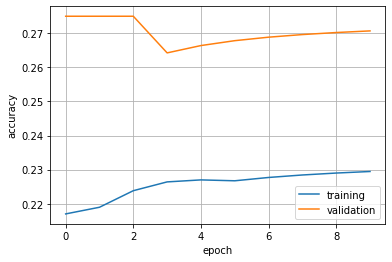

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

# Fine-tuning предобученной модели

Теперь попробуем поработать с предобученной сетью ResNet-18

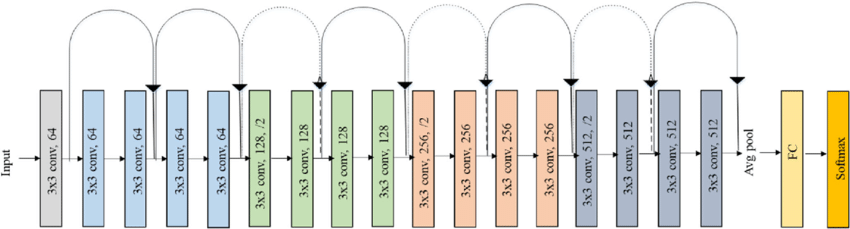

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True) # инициализируем модель
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def set_parameter_requires_grad(model):
  """
  Функция для заморозки весов модели
  """
  for param in model.parameters():
    param.requires_grad = False
            
set_parameter_requires_grad(resnet)

In [ ]:
# Меняем последний слой модели, чтобы он предсказывал 5 классов, а не 1000
# Когда мы заново определяем слой, у него по умолчанию стоит аттрибут requires_grad = True
# То есть этот полносвязный слой будет обучаться
resnet.fc = nn.Linear(512, 5)

In [ ]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in resnet.named_parameters():
    if param.requires_grad:
        print(name)

fc.weight
fc.bias


Запустим функцию обучения модели. Внимание - необходимо заново задать оптимизатор, чтобы он теперь работал с весами resnet

In [ ]:
resnet.to(device)
optimizer = torch.optim.Adam(params = resnet.parameters()) # алгоритм оптимизации
loss_track, accuracy_track = trainval(resnet, loaders, optimizer, epochs=5)

  0%|          | 0/104 [00:03<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

Сохраним веса модели:

In [ ]:
weights_fname = '/content/drive/MyDrive/ИТМО/ai_labs/lab3/flower-resnet.pth'
torch.save(resnet.state_dict(), weights_fname)

# Смотрим результат

И посмотрим как модель предсказывает

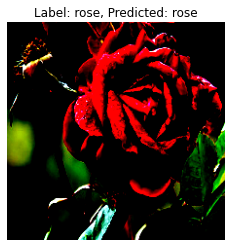

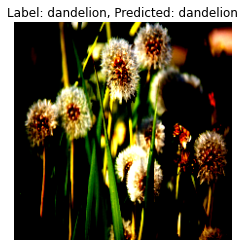

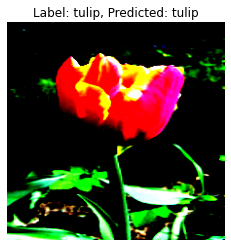

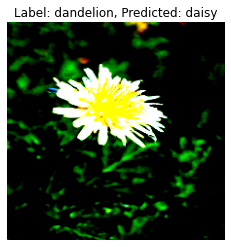

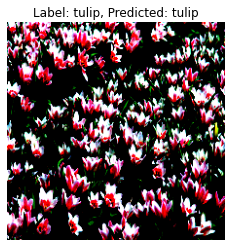

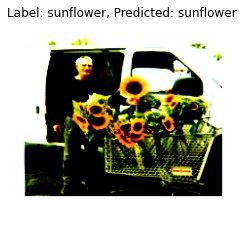

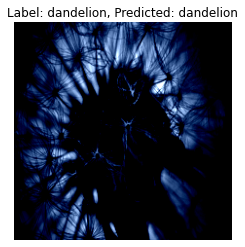

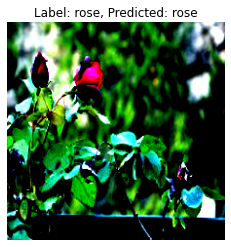

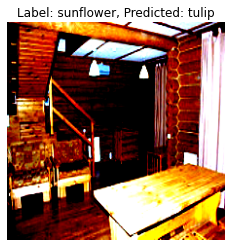

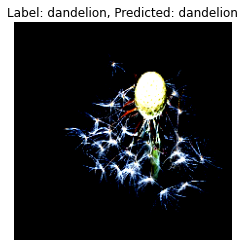

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    # Преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Получение прогнозов от модели
    yb = model(xb)
    # Выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # Получение метки класса
    return dataset.classes[preds[0].item()]

for i in range(30,40): #В range можно менять диапазон 
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, resnet)))
  plt.show()
  # print('Label:', dataset.classes[label], ',Predicted:', predict_image(img, resnet))

# Практическое задание 

В пракическом задание необходимо обучить еще одну сверточную архитектуру для задач классификации цветов. 

В выбранной Вами архитектуре также необходимо разобраться с основными её параметрами и принципами работы.

Посмотрите как использовать [модели в PyTorch](https://pytorch.org/vision/stable/models.html), выберите одну и используя transfer learning до-обучите модель на классификацию цветов. Чтобы это сделать замените ____ в ячейках ниже на работающий код.




In [ ]:
# Выберите модель из списка доступных в PyTorch моделей
# Не забудьте указать, что она модель должна быть предобучена!
model = torchvision.models.mobilenet_v3_large(pretrained=True)
model


MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

In [ ]:
set_parameter_requires_grad(model) # передайте модель в функцию для "заморозки" градиента

In [ ]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=5, bias=True)
    )

In [ ]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


In [ ]:
model.to(device) # Отправляем модель на GPU
optimizer = torch.optim.Adam(params = model.parameters()) # алгоритм оптимизации
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10) # запускаем обучение

100%|██████████| 104/104 [00:21<00:00,  4.82it/s]


[training] Epoch: 0.00. Loss: 0.56. Accuracy: 79.14% 


100%|██████████| 32/32 [00:06<00:00,  4.83it/s]


[validation] Epoch: 0.00. Loss: 0.36. Accuracy: 87.10% 


100%|██████████| 104/104 [00:21<00:00,  4.84it/s]


[training] Epoch: 1.00. Loss: 0.46. Accuracy: 82.90% 


100%|██████████| 32/32 [00:06<00:00,  4.81it/s]


[validation] Epoch: 1.00. Loss: 0.33. Accuracy: 88.75% 


100%|██████████| 104/104 [00:22<00:00,  4.54it/s]


[training] Epoch: 2.00. Loss: 0.41. Accuracy: 85.12% 


100%|██████████| 32/32 [00:06<00:00,  4.75it/s]


[validation] Epoch: 2.00. Loss: 0.32. Accuracy: 89.07% 


100%|██████████| 104/104 [00:21<00:00,  4.75it/s]


[training] Epoch: 3.00. Loss: 0.37. Accuracy: 86.65% 


100%|██████████| 32/32 [00:06<00:00,  4.83it/s]


[validation] Epoch: 3.00. Loss: 0.31. Accuracy: 89.25% 


100%|██████████| 104/104 [00:21<00:00,  4.79it/s]


[training] Epoch: 4.00. Loss: 0.34. Accuracy: 87.69% 


100%|██████████| 32/32 [00:06<00:00,  4.80it/s]


[validation] Epoch: 4.00. Loss: 0.30. Accuracy: 89.46% 


100%|██████████| 104/104 [00:21<00:00,  4.86it/s]


[training] Epoch: 5.00. Loss: 0.31. Accuracy: 88.63% 


100%|██████████| 32/32 [00:06<00:00,  4.75it/s]


[validation] Epoch: 5.00. Loss: 0.31. Accuracy: 89.15% 


100%|██████████| 104/104 [00:21<00:00,  4.81it/s]


[training] Epoch: 6.00. Loss: 0.29. Accuracy: 89.43% 


100%|██████████| 32/32 [00:06<00:00,  4.77it/s]


[validation] Epoch: 6.00. Loss: 0.32. Accuracy: 89.16% 


100%|██████████| 104/104 [00:21<00:00,  4.83it/s]


[training] Epoch: 7.00. Loss: 0.27. Accuracy: 90.02% 


100%|██████████| 32/32 [00:06<00:00,  4.73it/s]


[validation] Epoch: 7.00. Loss: 0.32. Accuracy: 89.25% 


100%|██████████| 104/104 [00:21<00:00,  4.81it/s]


[training] Epoch: 8.00. Loss: 0.26. Accuracy: 90.66% 


100%|██████████| 32/32 [00:06<00:00,  4.85it/s]


[validation] Epoch: 8.00. Loss: 0.32. Accuracy: 89.40% 


100%|██████████| 104/104 [00:21<00:00,  4.79it/s]


[training] Epoch: 9.00. Loss: 0.24. Accuracy: 91.27% 


100%|██████████| 32/32 [00:06<00:00,  4.79it/s]

[validation] Epoch: 9.00. Loss: 0.33. Accuracy: 89.43% 


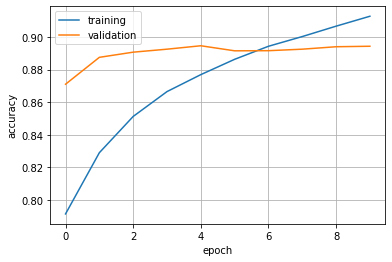

In [ ]:
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    # Преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Получение прогнозов от модели
    yb = model(xb)
    # Выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # Получение метки класса
    return dataset.classes[preds[0].item()]

for i in range(223,233):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img,model)))
  plt.show()
  # print('Label:', dataset.classes[label], ',Predicted:', predict_image(img, model))

По желанию, можно сохранить веса модели.

In [ ]:
weights_fname = '/content/drive/MyDrive/ИТМО/ai_labs/lab3/mobilenetv3.pth'
torch.save(model.state_dict(), weights_fname)

## Вопросы.

Как работает выбранная вами модель сверточной нейронной сети? Какие параметры?

В чем основные отличия между сверточной нейронной сетью и "обычной" полносвязной нейронной сетью?

Что такое transfer learning?

Что такое функция для заморозки весов модели?
